<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/Deep%20Learning/Deep_Neural_Networks-Intermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Library

In this second notebook we will add more power to the network by adding the following capabilities:


1.   He initialization
2.   Regularization
3.   Learning Rate Decay
2.   Solver Optimizations





<a name='1'></a>
## 1 - Packages

In [1]:
!pip install -Uqq ipdb
import ipdb
%pdb on

     |████████████████████████████████| 793 kB 4.2 MB/s 
     |████████████████████████████████| 381 kB 36.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.
Automatic pdb calling has been turned ON


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

#from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [3]:
def load_dataset(dataset='circles', n_train_samples=300, n_test_samples=100, train_noise=.05, test_noise=.05):
    if dataset != 'circles':
      return None, None, None, None

    train_X, train_Y = sklearn.datasets.make_circles(n_samples=n_train_samples, noise=train_noise)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=n_test_samples, noise=test_noise)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

## 2 - NN Implementation

In [43]:
class DeepNeuralNetwork():

  def __init__(self):
    # Define default values
    self._W = []                    # Array of weights - e.g., W1, W2, W3, ... WL+1
    self._b = []                    # Array of biases - e.g., b1, b2, b3, ..., bL+1
    self._layers_size = [0]         # Array of layers' size (includes input and output)
    self._activations_fn = [None]   # Array of activation functions for all the layers (None for the input layer)    
    self._lambd = 0.1               # Regularization coefficient
    self._keep_prob = 0.75          # Dropout probability coefficient

  
  def __get_layer_size(self, layer_num=None):
    """
    Returns the size of the given layer
    Arguments:
    layer_num -- int (0 -- num-layers-1) - 0 for the input layer
    """
    assert type(layer_num)==int, 'The layer num is mandatory and has to be of type int'
    assert (layer_num >= 0) and (layer_num < len(self.layers_size)), f'The accessible layer values are {0}-{len(self.layers_size)-1} - Value given: {layer_num}'

    return self._layers_size[layer_num]

  
  def infer_input_layer(self, X=None, display=False):
    """
    Adds a new input layer to the NN infering its size right from the data
    Arguments:
    X -- input vector, shape (number of features, number of examples)
    display - prints confirmation. Default = False
    """
    assert type(X) != type(None), 'The (nxm) shape X is mandatory'
    assert len(X.shape) == 2, 'The shape of X must be (nxm)'
    
    self._layers_size[0] = X.shape[0]
    if display:
      print(f'Model - added input layer \t\t Size = {self._layers_size[0]}')


  def add_hidden_layer(self, num_units=5, activation_fn='relu', display=False):
    """
    Adds a new hidden layer to the NN 
    Arguments:
    num_units -- default = 5
    activation_fn -- default = 'relu'
    display - prints confirmation. Default = False
    """
    assert num_units >= 1, 'The minimal number of layers is 1'
    assert activation_fn in ['relu', 'sigmoid', 'linear'], 'Supported activation functions are relu, sigmoid, and linear'

    self._layers_size.append(num_units)
    self._activations_fn.append(activation_fn)
    if display:
      print(f'Model - added hidden layer no: {len(self._layers_size)-1} \t Size = {num_units} \t Activation function = {activation_fn}')


  def add_output_layer(self, num_outputs=1, activation_fn='sigmoid', display=False):
    """
    Adds a new output layer to the NN 
    Arguments:
    num_outputs - default = 1
    activation_fn -- default = 'sigmoid'
    display - prints confirmation. Default = False
    """
    assert num_outputs >= 1, 'The minimal number of layers is 1'
    assert activation_fn in ['relu', 'sigmoid', 'linear'], 'Supported activation functions are relu, sigmoid, and linear'

    # Assert list has input and at least one hidden layer
    self._layers_size.append(num_outputs)
    self._activations_fn.append(activation_fn)
    if display:
      print(f'Model - Added output layer \t\t Size = {num_outputs} \t Activation function = {activation_fn}')


  def __get_deep(self):
    return len(self._layers_size)

  
  def set_regularization_coefficient(self, lambd=0.1):
    self._lambd = lambd


  def set_dropout_coefficient(self, prob=0.75):
    self._keep_prob = prob


  def __initialize(self):
    L = self.__get_deep()
    self._W = [None] * (L)
    self._b = [None] * (L)

    # Index 0 is used by the input layer
    # We need to include the output layer
    for l in range(1, L):                 
      curr = self._layers_size[l]
      prev = self._layers_size[l-1]
      self._W[l] = np.random.randn(curr, prev) * np.sqrt(2/prev)       # HE initialization
      self._b[l] = np.zeros((curr, 1))
      assert(self._W[l].shape == (curr, prev))
      assert(self._b[l].shape == (curr, 1))
    

  def __sigmoid(self, Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache


  def __relu(self, Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


  def __relu_backward(self, dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    #ipdb.set_trace(6)
    dZ[Z <= 0] = 0  
    assert (dZ.shape == Z.shape)
    return dZ


  def __sigmoid_backward(self, dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ


  def __linear_forward(self, A, W, b):
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache


  def __linear_activation_forward(self, A_prev, W, b, activation):
    Z, linear_cache = self.__linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = self.__sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = self.__relu(Z)
    # Implementing Dropout
    D = np.random.rand(A.shape[0], A.shape[1])
    D = (D < self._keep_prob).astype(int)
    A = np.multiply(A, D)
    A = A / self._keep_prob 
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache, D)
    return A, cache


  def __model_forward(self, X):
    L = self.__get_deep()
    caches = [None] * L
    A = X

    for l in range(1, L):
      A_prev = A 
      A, cache = self.__linear_activation_forward(A_prev, self._W[l], self._b[l], activation=self._activations_fn[l])
      caches[l] = cache
    
    assert(A.shape == (1,X.shape[1]))     
    return A, caches


  def __compute_cost(self, AL, Y):
    m = Y.shape[1]
    W = self._W[1:]    # getting rid of W0
    regularization = np.sum([np.sum(np.square(w)) for w in W]) * self._lambd/(2*m)
    regularization = np.squeeze(regularization)
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) 
    cost = np.squeeze(cost) + regularization
    assert(cost.shape == ())
    return cost


  def __linear_backward(self, dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T) + (self._lambd/m) * W
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)  
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db


      _, _, D = caches[l+1]
      dA[l] = np.multiply(dA[l], D)
      dA[l] = dA[l] / self._keep_prob


  def __linear_activation_backward(self, dA, cache, activation):
    linear_cache, activation_cache, D = cache

    if activation == "relu":
        dZ = self.__relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = self.__sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    return dA_prev, dW, db


  def __model_backward(self, AL, Y, caches):
    L = self.__get_deep()
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    dA = [None] * L
    dW = [None] * L
    db = [None] * L

    dA[L-1], dW[L-1], db[L-1] = self.__linear_activation_backward(dA=dAL, cache=caches[L-1], activation=self._activations_fn[L-1])

    for l in reversed(range(1, L-1)):
      dA[l], dW[l], db[l] = self.__linear_activation_backward(dA[l+1], caches[l], activation=self._activations_fn[l])

    return dW, db


  def __update_parameters(self, dW, db, learning_rate):
    L = self.__get_deep()
    # Update rule for each parameter. Use a for loop.
    for l in range(1, L):
        self._W[l] = self._W[l] - learning_rate * dW[l]
        self._b[l] = self._b[l] - learning_rate * db[l]


  def test(self, X, Y):
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = self.__model_forward(X)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    accuracy = np.sum((p == Y)/m)
    #print("Accuracy: "  + str(np.sum((p == Y)/m)))
    return accuracy, p


  def predict(self, X):
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = self.__model_forward(X)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    return p



  def fit(self, X, Y, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    costs = []
    self.__initialize()                         
    print_interval = int(num_iterations / 20)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
      AL, caches = self.__model_forward(X=X)
      cost = self.__compute_cost(AL=AL, Y=Y)
      dW, db = self.__model_backward(AL=AL, Y=Y, caches=caches)
      self.__update_parameters(dW, db, learning_rate=learning_rate)
              
      # Print the cost every 100 iterations
      if print_cost and i % print_interval == 0 or i == num_iterations - 1:
          print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
      if i % 100 == 0 or i == num_iterations:
          costs.append(cost)
      
    return costs


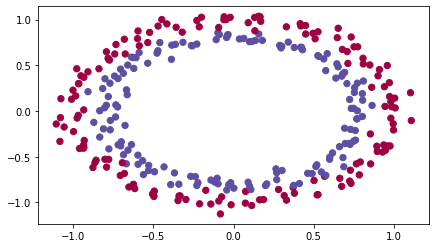

In [5]:
train_X, train_Y, test_X, test_Y = load_dataset(train_noise = .05, test_noise = .05)

In [44]:
# UNITEST
my_NN = DeepNeuralNetwork()
my_NN.infer_input_layer(train_X)
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_output_layer(1, 'sigmoid')
costs = my_NN.fit(X=train_X, Y=train_Y, num_iterations=15000, print_cost=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:212: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in multiply


ValueError: ignored

> <ipython-input-43-aed70d8bcf63>(224)__model_backward()
    222       dA[l], dW[l], db[l] = self.__linear_activation_backward(dA[l+1], caches[l], activation=self._activations_fn[l])
    223       _, _, D = caches[l+1]
--> 224       dA[l] = np.multiply(dA[l], D)
    225       dA[l] = dA[l] / self._keep_prob
    226 

ipdb> q


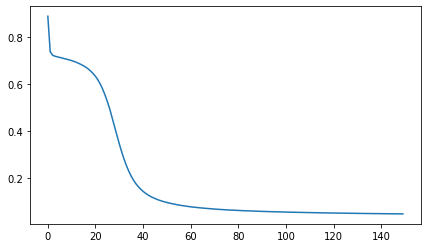

In [23]:
plt.plot(costs)

In [24]:
accuracy, pred_train = my_NN.test(X=train_X, Y=train_Y)
print(f"Cost = {costs[-1]} \t Accuracy = {accuracy}")

Cost = 0.046085021784626104 	 Accuracy = 1.0000000000000002


In [25]:
def plot_2D_decision_boundary(model, X, Y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 0.1, X[0, :].max() + 0.1
    y_min, y_max = X[1, :].min() - 0.1, X[1, :].max() + 0.1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    axes = plt.gca()
    axes.set_xlim([x_min, x_max])
    axes.set_ylim([y_min, y_max])
    plt.title("First Boundary")
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
    plt.show()

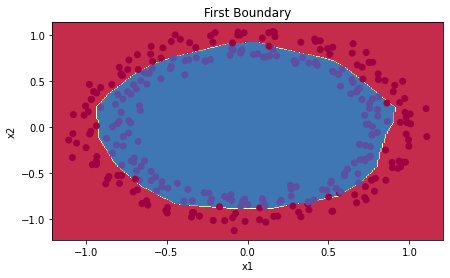

In [13]:
plot_2D_decision_boundary(lambda x: my_NN.predict(x.T), train_X, train_Y, title='Exercise 1')

In [14]:
accuracy, _ = my_NN.test(X=test_X, Y=test_Y)
print(f"Cost = {costs[-1]} ]t Accuracy = {accuracy}")

Cost = 0.09927456551857283 ]t Accuracy = 0.96


<a name='3'></a>
## 3 - Exercise #1

At this point we don't have any indication of how a deep NN will work on this problem. Major parameters, such as the # of layers, and the size of each layer are not understood.
We will assume the NN has 3 hidden layers and we will try different layer sizes starting from 2 units per layer and growing as a factor of 2 until reaching 64.

In [26]:
def exercise_1 (train_X, train_Y, test_X, test_Y, display=False):
  results = {}
  for i in range (1, 6):
    units = 2 ** i
    nn = DeepNeuralNetwork()
    nn.infer_input_layer(train_X, display)
    nn.add_hidden_layer(units, 'relu', display)
    nn.add_hidden_layer(units, 'relu', display)
    nn.add_hidden_layer(units, 'relu', display)
    nn.add_hidden_layer(units, 'relu', display)
    nn.add_output_layer(1, 'sigmoid', display)
    num_iterations = 20000
    costs = nn.fit(X=train_X, Y=train_Y, num_iterations=num_iterations, print_cost=False)
    accuracy_train, pred_train = nn.test(X=train_X, Y=train_Y)
    accuracy_test, pred_test = nn.test(X=test_X, Y=test_Y)

    if display:
      plot_2D_decision_boundary(lambda x: nn.predict(x.T), train_X, train_Y, title=f'Model in {i} units per hidden layer')

    results[i] = [costs, costs[-1], num_iterations, accuracy_train, accuracy_test]
    del nn

  return results

Model - added input layer 		 Size = 2
Model - added hidden layer no: 1 	 Size = 2 	 Activation function = relu
Model - added hidden layer no: 2 	 Size = 2 	 Activation function = relu
Model - added hidden layer no: 3 	 Size = 2 	 Activation function = relu
Model - added hidden layer no: 4 	 Size = 2 	 Activation function = relu
Model - Added output layer 		 Size = 1 	 Activation function = sigmoid
Cost after iteration 19999: 0.6950373278658448


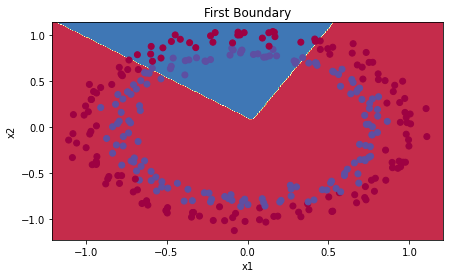

Model - added input layer 		 Size = 2
Model - added hidden layer no: 1 	 Size = 4 	 Activation function = relu
Model - added hidden layer no: 2 	 Size = 4 	 Activation function = relu
Model - added hidden layer no: 3 	 Size = 4 	 Activation function = relu
Model - added hidden layer no: 4 	 Size = 4 	 Activation function = relu
Model - Added output layer 		 Size = 1 	 Activation function = sigmoid
Cost after iteration 19999: 0.10720072085955046


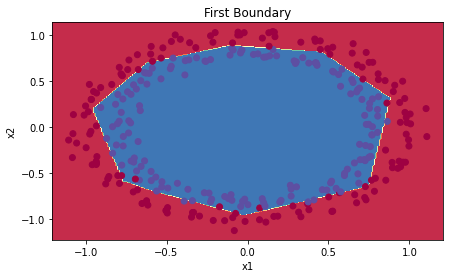

Model - added input layer 		 Size = 2
Model - added hidden layer no: 1 	 Size = 8 	 Activation function = relu
Model - added hidden layer no: 2 	 Size = 8 	 Activation function = relu
Model - added hidden layer no: 3 	 Size = 8 	 Activation function = relu
Model - added hidden layer no: 4 	 Size = 8 	 Activation function = relu
Model - Added output layer 		 Size = 1 	 Activation function = sigmoid
Cost after iteration 19999: 0.045274484470614385


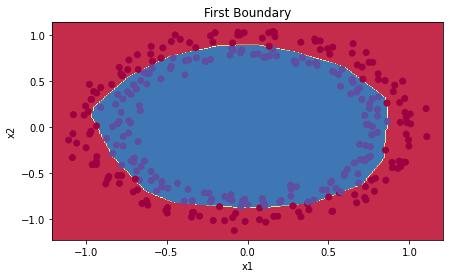

Model - added input layer 		 Size = 2
Model - added hidden layer no: 1 	 Size = 16 	 Activation function = relu
Model - added hidden layer no: 2 	 Size = 16 	 Activation function = relu
Model - added hidden layer no: 3 	 Size = 16 	 Activation function = relu
Model - added hidden layer no: 4 	 Size = 16 	 Activation function = relu
Model - Added output layer 		 Size = 1 	 Activation function = sigmoid
Cost after iteration 19999: 0.040257620135280364


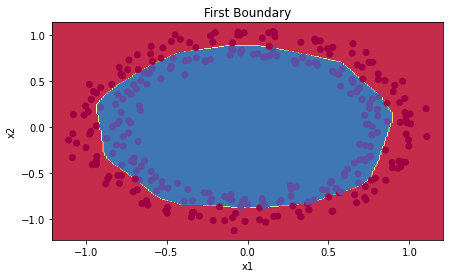

Model - added input layer 		 Size = 2
Model - added hidden layer no: 1 	 Size = 32 	 Activation function = relu
Model - added hidden layer no: 2 	 Size = 32 	 Activation function = relu
Model - added hidden layer no: 3 	 Size = 32 	 Activation function = relu
Model - added hidden layer no: 4 	 Size = 32 	 Activation function = relu
Model - Added output layer 		 Size = 1 	 Activation function = sigmoid
Cost after iteration 19999: 0.05650653339284049


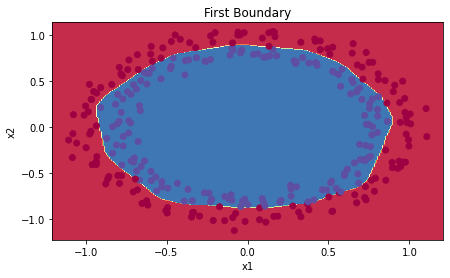

In [27]:
results = exercise_1(train_X, train_Y, test_X, test_Y, display=True)

In [28]:
import pandas as pd

res_df = pd.DataFrame(results).transpose()
res_df.columns = ['Costs', 'Cost', 'Iterations', 'Train Acc', 'Test Acc']
res_df

,Costs,Cost,Iterations,Train Acc,Test Acc
1,"[0.6954094199969091, 0.6954049800047926, 0.695...",0.695039,20000,0.5,0.51
2,"[0.730140962864186, 0.7003016985255647, 0.6957...",0.107276,20000,0.97,0.96
3,"[0.7483718293463796, 0.6914646728387052, 0.684...",0.045431,20000,0.99,0.95
4,"[0.7923125369280863, 0.7210044465242151, 0.706...",0.040308,20000,1.0,0.96
5,"[0.8867353181023349, 0.7322655348699236, 0.725...",0.056567,20000,1.0,0.97


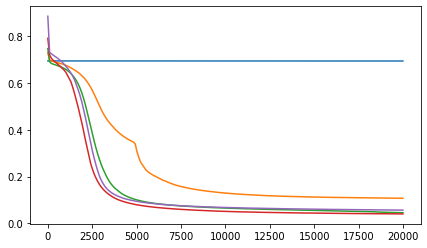

In [29]:
for i in range(0, res_df.shape[0]):
  y = res_df.iloc[i]['Costs']
  x = np.linspace(0, res_df.iloc[i]['Iterations'], len(y))
  plt.plot(x, y)

Next steps - Add regularization, learning decay, optimizations (adams)
Check feature transformation (polar coordinates)